In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import util
import seaborn as sns
import clean_data as cd
%matplotlib inline

In [2]:
pd2007 = cd.import_data(2007)
pd2012 = cd.import_data(2012)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
all_data = pd.concat([pd2007, pd2012])
all_data = all_data.set_index('id')

In [4]:
all_data = all_data[all_data['term'] == 36]

In [5]:
all_data.groupby('loan_status').size()

loan_status
Charged Off                                             19157
Current                                                 20721
Default                                                    33
Does not meet the credit policy. Status:Charged Off       615
Does not meet the credit policy. Status:Fully Paid       1701
Fully Paid                                             124130
In Grace Period                                           501
Late (16-30 days)                                         125
Late (31-120 days)                                        561
dtype: int64

In [6]:
EXCLUDE_STATUSES = [
    'Does not meet the credit policy. Status:Charged Off',
    'Does not meet the credit policy. Status:Fully Paid'
]

all_data = all_data[all_data['loan_status'] != 'Does not meet the credit policy. Status:Charged Off']
all_data = all_data[all_data['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid']
all_data.groupby('loan_status').size()

loan_status
Charged Off            19157
Current                20721
Default                   33
Fully Paid            124130
In Grace Period          501
Late (16-30 days)        125
Late (31-120 days)       561
dtype: int64

In [7]:
non_current_loans = all_data[all_data['loan_status'] != "Current"]

In [8]:
# current_loans['amnt_left'] = (current_loans['total_pymnt'] - current_loans['loan_amnt'])/current_loans['loan_amnt']
# non_current_loans.columns

In [9]:
# sns.distplot(non_current_loans['mths_since_last_delinq'])

In [21]:
def prepare_df_for_prediction(original_df):
    df = original_df.copy()

    util.df_binarize_column(df, 'home_ownership', drop_col=True)
    util.df_binarize_column(df, 'purpose', drop_col=True)
    util.df_binarize_column(df, 'verification_status', drop_col=True)
#     df['bin_pub_rec'] = (df['pub_rec'] > 1).astype(int)
#     df['bin_mths_since_last_delinq'] = (df['mths_since_last_delinq'] == -1).astype(int)
#     df['bin_mths_since_last_record'] = (df['mths_since_last_record'] == -1).astype(int)

    df['loan_status'] = (df['loan_status'] == 'Fully Paid').astype(int)
    
    return df
    
def get_X_y(df):
    y = df['loan_status']
    X = df.drop(['term', 'grade', 'sub_grade', 'addr_state', 'zip_code', 'earliest_cr_line', 'issue_d', 'loan_status', 'chargeoff_within_12_mths'], axis=1)
#     X = X.drop(['purpose', 'home_ownership', 'verification_status'], axis=1) # binarized columns
    X = X.drop(['mths_since_last_record', 'mths_since_last_delinq', 'pub_rec'], axis=1) # presence columns
    X = X.drop(['collection_recovery_fee', 'total_pymnt'], axis=1)
    return X, y

def output_confusion_matrices(model, X_train, y_train, X_test, y_test):
    print "Train score: %.2f" %model.score(X_train, y_train)
    cm_train = confusion_matrix(y_train, model.predict(X_train), labels=[True, False])

    print "Testing score:  %.2f" %model.score(X_test, y_test)
    cm_test = confusion_matrix(y_test, model.predict(X_test), labels=[True, False])

    print "Training confusion matrix:"
    print cm_train
    #print cm_train[0,:] * 1.0 / np.sum(y_train)
    #print cm_train[1,:] * 1.0 / (len(y_train) - np.sum(y_train))
    train_fpr = cm_train[1, 0] / np.sum(cm_train[:, 0]) 
    print "Train False positive rate: %.2f" %train_fpr

    
    print "Test confusion matrix:"
    print cm_test
    #print cm_test[0,:] / float(np.sum(y_test))
    #print cm_test[1,:] / float(len(y_test) - np.sum(y_test))
    test_fpr = cm_test[1, 0] / np.sum(cm_test[:, 0]) 
    print "Test False positive rate: %.2f" % test_fpr

    print "*" * 80
    
    return test_fpr

In [13]:
# convert status
# binarize columns
# classify
# predict

df = prepare_df_for_prediction(non_current_loans)
X, y = get_X_y(df)

In [20]:
print X.columns

Index([u'loan_amnt', u'int_rate', u'installment', u'emp_length', u'annual_inc',
       u'dti', u'delinq_2yrs', u'open_acc', u'revol_util', u'revol_bal',
       u'total_acc', u'inq_last_6mths', u'months_since_fst_credit', u'fico',
       u'home_ownership_NONE', u'home_ownership_OWN', u'home_ownership_OTHER',
       u'home_ownership_RENT', u'home_ownership_MORTGAGE',
       u'purpose_debt_consolidation', u'purpose_renewable_energy',
       u'purpose_house', u'purpose_car', u'purpose_medical',
       u'purpose_vacation', u'purpose_credit_card', u'purpose_educational',
       u'purpose_other', u'purpose_moving', u'purpose_wedding',
       u'purpose_small_business', u'purpose_major_purchase',
       u'purpose_home_improvement', u'verification_status_Not Verified',
       u'verification_status_Verified',
       u'verification_status_Source Verified'],
      dtype='object')


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Logistic Regression

In [15]:
true_weight = 0.1
lr = LogisticRegression(penalty='l2', C=100, class_weight={True: true_weight, False: 1 - true_weight})

In [23]:
lr.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
for false_weight in [15, 16, 17, 18, 19, 20]:
    lr = LogisticRegression(penalty='l2', C=100, class_weight={False: false_weight})
    lr.fit(X_train, y_train)
    output_confusion_matrices(lr, X_train, y_train, X_test, y_test)

Train score: 0.25
Testing score:  0.25
Training confusion matrix:
[[12882 86381]
 [  562 15780]]
Train False positive rate: 0.04
Test confusion matrix:
[[ 3298 21569]
 [  142  3893]]
Test False positive rate: 0.04
********************************************************************************
Train score: 0.23
Testing score:  0.23
Training confusion matrix:
[[10237 89026]
 [  412 15930]]
Train False positive rate: 0.04
Test confusion matrix:
[[ 2648 22219]
 [  108  3927]]
Test False positive rate: 0.04
********************************************************************************
Train score: 0.21
Testing score:  0.21
Training confusion matrix:
[[ 8557 90706]
 [  315 16027]]
Train False positive rate: 0.04
Test confusion matrix:
[[ 2201 22666]
 [   86  3949]]
Test False positive rate: 0.04
********************************************************************************
Train score: 0.20
Testing score:  0.20
Training confusion matrix:
[[ 6836 92427]
 [  221 16121]]
Train False positi

In [ ]:
results = {}
reg_type = 'l2'
c_val = 1
for c_val in np.arange(0.01, 1.11, 0.1):
    for true_weight in np.arange(0, 0.6, 0.1):
        print "#" * 80
        print "Training with %s regularization, c = %.2f, class weight = %.2f:%.2f" %(reg_type, c_val, true_weight, 1-true_weight)
        c_weight = {True: true_weight, False: 1 - true_weight}
        lr = LogisticRegression(penalty='l2', C=1, class_weight={True: true_weight, False: 1 - true_weight})
        lr.fit(X_train, y_train)
        results[true_weight] = output_confusion_matrices(lr, X_train, y_train, X_test, y_test)

################################################################################
Training with l2 regularization, c = 0.01, class weight = 0.00:1.00
Train score: 0.14
Testing score:  0.14
Train False positive rate: nan

Test False positive rate: nan
################################################################################
Training with l2 regularization, c = 0.01, class weight = 0.10:0.90
Train score: 0.43
Testing score:  0.43
Train False positive rate: 0.07

Test False positive rate: 0.07
################################################################################
Training with l2 regularization, c = 0.01, class weight = 0.20:0.80
Train score: 0.76
Testing score:  0.76
Train False positive rate: 0.11

In [25]:

print sorted(zip(map(lambda x: round(x, 4), np.abs(lr.coef_[0])), X.columns), 
             reverse=True)

[(0.8392, 'purpose_small_business'), (0.8335, 'home_ownership_NONE'), (0.7725, 'home_ownership_MORTGAGE'), (0.7012, 'home_ownership_OWN'), (0.6631, 'home_ownership_RENT'), (0.5821, 'purpose_educational'), (0.4585, 'home_ownership_OTHER'), (0.4203, 'purpose_renewable_energy'), (0.3293, 'purpose_medical'), (0.3081, 'verification_status_Source Verified'), (0.2774, 'purpose_other'), (0.2653, 'verification_status_Not Verified'), (0.2641, 'purpose_moving'), (0.2064, 'purpose_home_improvement'), (0.2063, 'purpose_vacation'), (0.2004, 'purpose_house'), (0.1944, 'verification_status_Verified'), (0.1157, 'purpose_wedding'), (0.1038, 'purpose_debt_consolidation'), (0.0917, 'inq_last_6mths'), (0.0836, 'int_rate'), (0.0418, 'purpose_credit_card'), (0.0336, 'purpose_car'), (0.0202, 'open_acc'), (0.0168, 'dti'), (0.0109, 'total_acc'), (0.009, 'purpose_major_purchase'), (0.0084, 'delinq_2yrs'), (0.0078, 'emp_length'), (0.0042, 'fico'), (0.001, 'installment'), (0.0009, 'revol_util'), (0.0002, 'months_s

# Random Forest

In [80]:
rfc = RandomForestClassifier(n_estimators=150, max_features=None, max_depth=20,
                             n_jobs=4, min_samples_split=10, class_weight={True: 0.1, False: 0.9})

In [81]:
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={False: 0.9, True: 0.1},
            criterion='gini', max_depth=20, max_features=None,
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
print sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X.columns), 
             reverse=True)

[(0.1436, 'int_rate'), (0.0981, 'dti'), (0.0934, 'annual_inc'), (0.0919, 'revol_bal'), (0.089, 'months_since_fst_credit'), (0.0876, 'revol_util'), (0.0676, 'installment'), (0.0649, 'total_acc'), (0.0486, 'fico'), (0.0473, 'open_acc'), (0.0353, 'emp_length'), (0.0293, 'loan_amnt'), (0.0192, 'inq_last_6mths'), (0.0114, 'delinq_2yrs'), (0.0076, 'purpose_credit_card'), (0.006, 'verification_status_Source Verified'), (0.0056, 'home_ownership_OWN'), (0.0055, 'verification_status_Verified'), (0.0055, 'purpose_debt_consolidation'), (0.0053, 'verification_status_Not Verified'), (0.0051, 'home_ownership_MORTGAGE'), (0.005, 'home_ownership_RENT'), (0.0049, 'purpose_small_business'), (0.0047, 'purpose_home_improvement'), (0.0042, 'purpose_other'), (0.0029, 'purpose_major_purchase'), (0.0021, 'purpose_wedding'), (0.0018, 'purpose_car'), (0.0017, 'purpose_medical'), (0.0014, 'purpose_vacation'), (0.0014, 'purpose_moving'), (0.0011, 'purpose_house'), (0.0004, 'purpose_renewable_energy'), (0.0003, 'pu

1.0
0.858987578284
0.0149253731343
0.86196408483


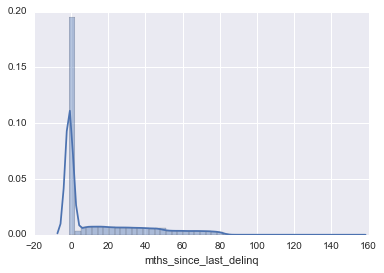

In [83]:
def explore(threshold, col_name):
    loans_with_col = df[df[col_name] > threshold]
    loans_without_col = df[df[col_name] < threshold]
    print np.sum(loans_with_pr['loan_status']) / (np.sum(len(loans_with_col)) * 1.0)
    print np.sum(loans_without_pr['loan_status']) / (np.sum(len(loans_without_col)) * 1.0)

# explore(10, 'pub_rec')
# explore(1, 'chargeoff_within_12_mths')

# sns.distplot(df['mths_since_last_delinq'])


In [96]:
output_confusion_matrices(rfc, X_train, y_train, X_test, y_test)

Train score: 0.95
Testing score:  0.80
Training confusion matrix:
[[93419  5844]
 [   45 16297]]
[ 0.9411261  0.0588739]
[ 0.00275364  0.99724636]
Test confusion matrix:
[[22187  2680]
 [ 3115   920]]
[ 0.89222665  0.10777335]
[ 0.77199504  0.22800496]


# Benchmark

In [30]:
imported_benchmark_data = cd.import_data(2012)
imported_benchmark_data = imported_benchmark_data.set_index('id')

imported_benchmark_data = imported_benchmark_data[imported_benchmark_data['term'] == 36]

EXCLUDE_STATUSES = [
    'Does not meet the credit policy. Status:Charged Off',
    'Does not meet the credit policy. Status:Fully Paid'
]

imported_benchmark_data = imported_benchmark_data[imported_benchmark_data['loan_status'] != 'Does not meet the credit policy. Status:Charged Off']
imported_benchmark_data = imported_benchmark_data[imported_benchmark_data['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid']
imported_benchmark_data.groupby('loan_status').size()

imported_benchmark_data = imported_benchmark_data[imported_benchmark_data['loan_status'] != "Current"]

In [31]:
benchmark_data = imported_benchmark_data
benchmark_data['total_return'] =  (benchmark_data['total_pymnt'] - 
                                   benchmark_data['collection_recovery_fee']) / benchmark_data['loan_amnt']

def total_return_for_grade(df, grade):
    matching_loans = df[df['grade'] == grade]
    return np.average(matching_loans['total_return'])

def total_return_for_grades(df, grades):
    total_returns = []

    for grade in grades:
        total_returns.append(total_return_for_grade(df, grade))

    return np.average(total_returns)

print "Benchmark for all non-current, 36-month, loans: %.2f" % total_return_for_grades(benchmark_data, ["A", "B", "C"])

Benchmark for all non-current, 36-month, loans: 1.08


In [33]:
pibd = prepare_df_for_prediction(imported_benchmark_data)
benchmark_X, benchmark_y = get_X_y(pibd)

#benchmark_X.drop('home_ownership_ANY', axis=1, inplace=1)
benchmark_X.drop('total_return', axis=1, inplace=1)

for col in set(X_train.columns).difference(set(benchmark_X.columns)):
    benchmark_X[col] = np.zeros((len(benchmark_X), 1))

In [34]:
predictions = lr.predict(benchmark_X)

In [39]:
indices = imported_benchmark_data[predictions == 1].index
good_loans = imported_benchmark_data.ix[indices]
print "Benchmark for all non-current, 36-month, loans: %.2f" % total_return_for_grades(good_loans, ["A", "B", "C"])

print good_loans.groupby('grade').size()

Benchmark for all non-current, 36-month, loans: 1.09
grade
A    3425
B     276
C      64
D      12
G       1
dtype: int64


In [36]:
print "Train score: %.2f" % lr.score(benchmark_X, pibd['loan_status'])
cm_benchmark = confusion_matrix(pibd['loan_status'], lr.predict(benchmark_X), labels=[True, False])

print "Training confusion matrix:"
print cm_benchmark

print cm_benchmark[0,:] * 1.0 / np.sum(benchmark_y)
print cm_benchmark[1,:] * 1.0 / (len(benchmark_y) - np.sum(benchmark_y))

Train score: 0.18
Training confusion matrix:
[[ 3663 95335]
 [  115 17207]]
[ 0.03700075  0.96299925]
[ 0.00663896  0.99336104]


In [ ]:
benchmark_X.columns